In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataset_testing.csv")

df = df[df["type"].isin(["primary", "secondary"])]
# Label encode
df["type"] = df["type"].map({"primary": 1, "secondary": 0})

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["type"].tolist(), test_size=0.2, stratify=df["type"]
)

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from datasets import Dataset

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})

def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 19/19 [00:00<00:00, 3136.11 examples/s]


In [4]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./scibert_citation",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

trainer.train()

C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,0.774800
20,0.438400


TrainOutput(global_step=27, training_loss=0.521259793528804, metrics={'train_runtime': 122.7358, 'train_samples_per_second': 1.76, 'train_steps_per_second': 0.22, 'total_flos': 28415993978880.0, 'train_loss': 0.521259793528804, 'epoch': 3.0})

In [5]:
trainer.evaluate()

C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.3605559170246124,
 'eval_runtime': 3.3791,
 'eval_samples_per_second': 5.623,
 'eval_steps_per_second': 0.888,
 'epoch': 3.0}

In [6]:
model.save_pretrained("scibert_citation_classifier")
tokenizer.save_pretrained("scibert_citation_classifier")

('scibert_citation_classifier\\tokenizer_config.json',
 'scibert_citation_classifier\\special_tokens_map.json',
 'scibert_citation_classifier\\vocab.txt',
 'scibert_citation_classifier\\added_tokens.json',
 'scibert_citation_classifier\\tokenizer.json')

In [7]:
test_text = "The method is based on the integration of data from satellite photos and data from certified, publicly accessible shoreline data."

In [8]:
import torch

# Pilih device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenisasi dan pindahkan ke device
inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding=True, max_length=256)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Prediksi
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    pred_label = outputs.logits.argmax(dim=1).item()

# Interpretasi
label_map = {1: "Primary", 0: "Secondary"}
print("Predicted label:", label_map[pred_label])

Predicted label: Secondary


In [10]:
%pip install pymupdf nltk --quiet

Note: you may need to restart the kernel to use updated packages.


In [9]:
import fitz  # PyMuPDF
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aqiza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def extract_sentences_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    # Split manual dengan titik
    sentences = [s.strip() for s in full_text.split('.') if len(s.strip().split()) > 4]
    return sentences

In [11]:
def predict_sentences(sentences, model, tokenizer, device):
    label_map = {1: "Primary", 0: "Secondary"}
    predictions = []

    model.to(device)
    model.eval()

    for sent in sentences:
        inputs = tokenizer(sent, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
        predictions.append((sent, label_map[pred]))

    return predictions

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aqiza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
pdf_path = "10.5194_essd-2023-187.pdf"  # ganti sesuai nama file PDF kamu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ekstrak & prediksi
sentences = extract_sentences_from_pdf(pdf_path)
results = predict_sentences(sentences, model, tokenizer, device)

# Tampilkan 10 hasil pertama
for i, (text, label) in enumerate(results[:10]):
    print(f"{i+1}. [{label}] {text}\n")

1. [Primary] Data, 16, 1265–1282, 2024
https://doi

2. [Primary] This work is distributed under
the Creative Commons Attribution 4

3. [Primary] Metazoan zooplankton in the Bay of Biscay: a 16-year
record of individual sizes and abundances obtained
using the ZooScan and ZooCAM imaging systems
Nina Grandremy1,⋆, Paul Bourriau1, Edwin Daché2, Marie-Madeleine Danielou3, Mathieu Doray1,
Christine Dupuy4, Bertrand Forest5, Laetitia Jalabert6, Martin Huret7, Sophie Le Mestre7,
Antoine Nowaczyk8, Pierre Petitgas9, Philippe Pineau4, Justin Rouxel10, Morgan Tardivel10, and
Jean-Baptiste Romagnan1,⋆
1DECOD (Ecosystem Dynamics and Sustainability), IFREMER, INRAE, Institut Agro, Nantes,
Centre Atlantique, Rue de l’Ile d’Yeu, BP 21105, 44311 Nantes CEDEX 03, France
2Unité Biologie et Ecologie des Ecosystèmes marins Profonds, Laboratoire Environnement Profond,
Ifremer Centre Bretagne, ZI de la Pointe du Diable, CS 10070, 29280 Plouzané, France
3Unité DYNECO-PELAGOS, Laboratoire d’Ecologie Pélagique,

C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


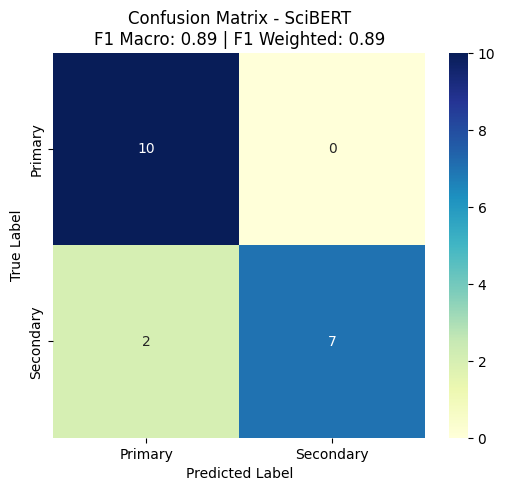


Classification Report:

              precision    recall  f1-score   support

     Primary       0.83      1.00      0.91        10
   Secondary       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

# Use val_labels as y_true
y_true = ["Primary" if l == 1 else "Secondary" for l in val_labels]

# Generate predictions for validation set
model.eval()
val_preds = []
label_map = {1: "Primary", 0: "Secondary"}
device = model.device

for text in val_texts:
	inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
	inputs = {k: v.to(device) for k, v in inputs.items()}
	with torch.no_grad():
		outputs = model(**inputs)
		pred = outputs.logits.argmax(dim=1).item()
	val_preds.append(label_map[pred])

# Confusion matrix
cm = confusion_matrix(y_true, val_preds, labels=["Primary", "Secondary"])
f1_macro = f1_score(y_true, val_preds, average='macro')
f1_weighted = f1_score(y_true, val_preds, average='weighted')

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Primary", "Secondary"], yticklabels=["Primary", "Secondary"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SciBERT\nF1 Macro: {f1_macro:.2f} | F1 Weighted: {f1_weighted:.2f}")
plt.show()

# Optional: print laporan lengkap
print("\nClassification Report:\n")
print(classification_report(y_true, val_preds))

In [21]:
df["type"].value_counts()

type
1    46
0    45
Name: count, dtype: int64

In [22]:
import pandas as pd

df = pd.read_csv("train_labels.csv")
df = df[df["type"].isin(["primer", "sekunder"])]  # Hapus yang missing
df["label"] = df["type"].map({"primer": 1, "sekunder": 0})

In [23]:
print(df.columns)

Index(['article_id', 'dataset_id', 'type', 'label'], dtype='object')


In [24]:
def predict_article(file_path):
    text = extract_text_from_pdf(file_path)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        pred = outputs.logits.argmax(dim=1).item()
    return "Primer" if pred == 1 else "Sekunder"

In [25]:
import fitz  # PyMuPDF

def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    text = "\n".join([page.get_text() for page in doc])
    return text

In [26]:
# Misal nama file PDF-nya:
file_path = "10.5194_essd-2023-187.pdf"

# Panggil fungsi prediksi
hasil = predict_article(file_path)

# Cetak hasil
print("Label prediksi artikel:", hasil)

Label prediksi artikel: Primer


C:\Users\aqiza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [27]:
import os

folder_path = "pdf_folder"
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        path = os.path.join(folder_path, filename)
        label = predict_article(path)
        print(f"{filename} → {label}")

10.1002_2017jc013030.pdf → Primer
10.1002_anie.201916483.pdf → Primer
10.1002_anie.202005531.pdf → Primer
10.1002_anie.202007717.pdf → Primer
10.1002_chem.201902131.pdf → Primer
10.1002_chem.201903120.pdf → Primer
10.1002_chem.202000235.pdf → Primer
10.1002_chem.202001412.pdf → Primer
10.1002_chem.202001668.pdf → Primer
10.1002_chem.202003167.pdf → Primer
10.1002_cssc.202201821.pdf → Primer
10.1002_ece3.3985.pdf → Primer
10.1002_ece3.4466.pdf → Primer
10.1002_ece3.5260.pdf → Primer
10.1002_ece3.5395.pdf → Primer
10.1002_ece3.6144.pdf → Primer
10.1002_ece3.6303.pdf → Primer
10.1002_ece3.6784.pdf → Primer
10.1002_ece3.961.pdf → Primer
10.1002_ece3.9627.pdf → Primer
10.1002_ecs2.1280.pdf → Primer
10.1002_ecs2.4619.pdf → Primer
10.1002_ejic.201900904.pdf → Primer
10.1002_ejoc.202000139.pdf → Primer
10.1002_ejoc.202000916.pdf → Primer
10.1002_esp.5058.pdf → Primer
10.1002_esp.5090.pdf → Primer
10.1002_mp.14424.pdf → Primer
10.1002_nafm.10870.pdf → Primer
10.1007_jhep07(2018)134.pdf → Primer